# Machine Learning and Pattern Recognition - Project 3
Eleftheria Vrachoriti


Start by importing all the libraries that we are going to use later.

In [1]:
import zipfile

import numpy as np

import torch
import torch.nn as nn
from torch.nn import ELU, Hardshrink, Hardsigmoid, Hardtanh, Hardswish, LeakyReLU, LogSigmoid
from torch.nn import PReLU, ReLU, ReLU6, RReLU, SELU, CELU, GELU, Sigmoid, SiLU, Mish, Softplus, Softshrink, Softsign, Tanh, Tanhshrink
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
%pip install torchmetrics
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/519.2 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 235.5/519.2 kB 7.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.0 MB/s eta 0:00:00


In [3]:
from torch.optim import Adadelta, Adagrad, Adam, AdamW, SparseAdam, Adamax, ASGD, LBFGS, NAdam, RAdam, RMSprop, Rprop, SGD
from torch.optim.lr_scheduler import LambdaLR, MultiplicativeLR, StepLR, MultiStepLR, ConstantLR
from torch.optim.lr_scheduler import LinearLR, ExponentialLR, PolynomialLR, CyclicLR
import matplotlib.pyplot as plt
import random
import sys
import os
from timeit import default_timer as timer

Mount drive.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Unzip data folder to root directory.

In [5]:
data_path_zip = '/content/gdrive/MyDrive/data.zip'
data_path = '/content/'

data_zip = zipfile.ZipFile(data_path_zip, 'r')
data_zip.extractall(data_path)
data_zip.close()

# Question 1 - Feedforward Neural Network

### Step 1 - Load data (mfccs)

Load train, test and validation data (mfccs).

In [ ]:
mfcc_x_train = np.load('/content/music_genre_data_di/train/mfccs/X.npy')
mfcc_y_train = np.load('/content/music_genre_data_di/train/mfccs/labels.npy')

mfcc_x_test  = np.load('/content/music_genre_data_di/test/mfccs/X.npy')
mfcc_y_test  = np.load('/content/music_genre_data_di/test/mfccs/labels.npy')

mfcc_x_val   = np.load('/content/music_genre_data_di/val/mfccs/X.npy')
mfcc_y_val   = np.load('/content/music_genre_data_di/val/mfccs/labels.npy')

Find unique labels in train dataset.

We are expecting 4 different labels.

In [ ]:
np.unique(mfcc_y_train)

array(['blues', 'classical', 'hiphop', 'rock_metal_hardrock'],
      dtype='<U19')

Convert labels from strings <code>classical</code>, <code>blues</code>, <code>hiphop</code> and <code>rock_metal_hardrock</code> to integer values <code>0</code>, <code>1</code>, <code>2</code> and <code>3</code>.

In [9]:
labels_str_to_int = {'classical'          : 0,
                     'blues'              : 1 ,
                     'hiphop'             : 2,
                     'rock_metal_hardrock': 3}

def convert_labels(string_labels):
  int_labels = []
  for label in string_labels:
    int_labels.append(labels_str_to_int[label])
  return np.array(int_labels)

In [ ]:
mfcc_y_train = convert_labels(mfcc_y_train)
mfcc_y_test  = convert_labels(mfcc_y_test)
mfcc_y_val   = convert_labels(mfcc_y_val)

Use Pytorch Dataloaders to load data into the Neural Network.

In [ ]:
train_dataloader = DataLoader(list(zip(mfcc_x_train, mfcc_y_train)), batch_size=16, shuffle=True)
test_dataloader  = DataLoader(list(zip(mfcc_x_test, mfcc_y_test)), batch_size=16, shuffle=True)
val_dataloader   = DataLoader(list(zip(mfcc_x_val, mfcc_y_val)), batch_size=16, shuffle=True)

Define device.

This will be useful for the next steps.

In [40]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(device)

cpu


### Step 2 - Definintion of the Neural Network

The Neural Network that will be used consists of $4$ layers with $26$, $128$, $32$ and $4$ perceptrons respectively.

The first layer is the input layer and it consists of $26$ perceptrons, because the input size is $26$.

The next two layers that consist of $128$ and $32$ perceptrons respectively are the hidden layers.

The last layer is the output layer and it consists of $4$ perceptrons, because the number of different labels is $4$.
<br></br>

The code shown in compimentary courses has been modified in order to implement the Neural Network that was described above.

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # data is one-dimensional, there's no need to flatten it
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(26, 128), # input size = 26 -> number of perceptrons in 1st hidden layer = 128
        nn.ReLU(),
        nn.Linear(128, 32), # number of perceptrons in 1st hidden layer = 128 ->
                            # number of perceptrons in 2nd hidden layer = 32
        nn.ReLU(),
        nn.Linear(32, 4)    # number of perceptrons in 2nd hidden layer = 32 ->
                            # number of different labels = 4
    )

  def forward(self, x):
    # data is one-dimensional, there's no need to flatten it
    return self.linear_relu_stack(x)

### Step 3 - Definition of the training procedure

This function trains the given Neural Network for the given number of epochs using the given dataloader, optimizer and loss function.

The Neural Network is returned after training it for the given number of epochs.
<br></br>

The code shown in compimentary courses has been modified in order to implement the training procedure was described above.

In [ ]:
def train_neural_network(epochs, optimizer, dataloader, loss_function, model):
  size = len(dataloader.dataset)

  for epoch in range(0, epochs):
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(x.float())
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print()

  return model

### Step 4 - Definition of the testing procedure

This function tests the given Neural Network on the dataset that can be retreived in batches using the given dataloader and returns the values of three metrics; loss, f1 macro averaged score and accuracy and the confusion matrix.
<br></br>

The code shown in compimentary courses has been modified in order to implement the testing procedure was described above.

In [ ]:
def test_neural_network(dataloader, loss_function, model):
  size = len(dataloader.dataset)
  test_loss, correct = 0, 0

  predictions = []
  labels = []
  with torch.no_grad():
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(x.float())
      predictions.append(prediction.argmax(1))
      test_loss += loss_function(prediction, y)
      correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

      # keep labels for later
      labels.append(y)

  test_loss /= size
  accuracy = 100 * (correct / size)
  predictions = torch.cat(predictions)
  labels = torch.cat(labels)
  f1_macro_avg = f1_score(predictions, labels, task='multiclass', num_classes=4, average='macro')

  # move confusion matrix to GPU if GPU is in use
  confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
  print("Test Error:")
  print(f"Avg loss               : {test_loss:>8f}")
  print(f"f1 macro averaged score: {f1_macro_avg:>8f}")
  print(f"Accuracy               : {accuracy:>0.1f}%")
  print(f"Confusion matrix       :")
  print(confusion_matrix(predictions, labels))

  return test_loss, f1_macro_avg, accuracy, confusion_matrix

### Step 5 - Training using CPU

Initialize model.

In [ ]:
cpu_model = NeuralNetwork().to(device)
print(cpu_model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


Train model using $learning$ $rate = 0.002$, Stochastic Gradient Descent optimizer and Cross Entropy Loss function for $30$ epochs.

In [ ]:
learning_rate = 0.002
optimizer = SGD(params=cpu_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

Train our Neural Network using the CPU.

In [ ]:
%%time
cpu_model = train_neural_network(epochs, optimizer, train_dataloader, loss_function, cpu_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.327188  [ 1200/ 3200]
loss: 1.379151  [ 1216/ 3200]
loss: 1.404680  [ 1232/ 3200]
loss: 1.353718  [ 1248/ 3200]
loss: 1.336174  [ 1264/ 3200]
loss: 1.388414  [ 1280/ 3200]
loss: 1.340556  [ 1296/ 3200]
loss: 1.384500  [ 1312/ 3200]
loss: 1.315806  [ 1328/ 3200]
loss: 1.357095  [ 1344/ 3200]
loss: 1.375440  [ 1360/ 3200]
loss: 1.338940  [ 1376/ 3200]
loss: 1.381393  [ 1392/ 3200]
loss: 1.353540  [ 1408/ 3200]
loss: 1.334444  [ 1424/ 3200]
loss: 1.371490  [ 1440/ 3200]
loss: 1.344838  [ 1456/ 3200]
loss: 1.361484  [ 1472/ 3200]
loss: 1.349878  [ 1488/ 3200]
loss: 1.350991  [ 1504/ 3200]
loss: 1.351029  [ 1520/ 3200]
loss: 1.348270  [ 1536/ 3200]
loss: 1.359521  [ 1552/ 3200]
loss: 1.341205  [ 1568/ 3200]
loss: 1.344490  [ 1584/ 3200]
loss: 1.346338  [ 1600/ 3200]
loss: 1.322726  [ 1616/ 3200]
loss: 1.331240  [ 1632/ 3200]
loss: 1.384868  [ 1648/ 3200]
loss: 1.346686  [ 1664/ 3200]
loss: 1.342937  [ 1680/ 3200]
loss: 1.338222 

Test our Neural Network on the test data using the CPU.

In [ ]:
%%time
results = test_neural_network(test_dataloader, loss_function, cpu_model)

Test Error:
Avg loss               : 0.061879
f1 macro averaged score: 0.609656
Accuracy               : 62.1%
Confusion matrix       :
tensor([[242,  31,  14,  10],
        [ 27, 103, 120,  74],
        [ 14,  51, 285,   6],
        [ 47,  61,  67, 224]])
CPU times: user 39.4 ms, sys: 2.75 ms, total: 42.2 ms
Wall time: 72.1 ms


### Step 6 - Training using GPU

Make sure that the GPU is in use.

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(device)

cuda


Initialize model.

In [ ]:
gpu_model = NeuralNetwork().to(device)
print(gpu_model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


Train model using $learning$ $rate = 0.002$, Stochastic Gradient Descent optimizer and Cross Entropy Loss function for $30$ epochs.

In [ ]:
learning_rate = 0.002
optimizer = SGD(params=gpu_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

Train our Neural Network using the GPU.

In [ ]:
%%time
gpu_model = train_neural_network(epochs, optimizer, train_dataloader, loss_function, gpu_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.316662  [ 1200/ 3200]
loss: 1.358754  [ 1216/ 3200]
loss: 1.338683  [ 1232/ 3200]
loss: 1.334791  [ 1248/ 3200]
loss: 1.303640  [ 1264/ 3200]
loss: 1.380085  [ 1280/ 3200]
loss: 1.290490  [ 1296/ 3200]
loss: 1.372623  [ 1312/ 3200]
loss: 1.338779  [ 1328/ 3200]
loss: 1.274673  [ 1344/ 3200]
loss: 1.325277  [ 1360/ 3200]
loss: 1.290899  [ 1376/ 3200]
loss: 1.358966  [ 1392/ 3200]
loss: 1.314071  [ 1408/ 3200]
loss: 1.311050  [ 1424/ 3200]
loss: 1.352547  [ 1440/ 3200]
loss: 1.363265  [ 1456/ 3200]
loss: 1.308970  [ 1472/ 3200]
loss: 1.315032  [ 1488/ 3200]
loss: 1.338723  [ 1504/ 3200]
loss: 1.343131  [ 1520/ 3200]
loss: 1.340748  [ 1536/ 3200]
loss: 1.380608  [ 1552/ 3200]
loss: 1.333950  [ 1568/ 3200]
loss: 1.315450  [ 1584/ 3200]
loss: 1.327723  [ 1600/ 3200]
loss: 1.329021  [ 1616/ 3200]
loss: 1.330154  [ 1632/ 3200]
loss: 1.335737  [ 1648/ 3200]
loss: 1.317521  [ 1664/ 3200]
loss: 1.356256  [ 1680/ 3200]
loss: 1.312389 

Test our Neural Network on the test data using the GPU.

In [ ]:
%%time
results = test_neural_network(test_dataloader, loss_function, gpu_model)

Test Error:
Avg loss               : 0.060366
f1 macro averaged score: 0.583550
Accuracy               : 61.3%
Confusion matrix       :
tensor([[244,  23,  11,  19],
        [ 39,  61,  77, 147],
        [ 21,  47, 241,  47],
        [ 43,  21,  38, 297]], device='cuda:0')
CPU times: user 75.3 ms, sys: 2.62 ms, total: 77.9 ms
Wall time: 86.6 ms


The GPU was a little slower than the CPU.

This could have been caused due to the overhead of the GPU accessing the computer's memory. [[1]](#reference)

### Step 7 - Validation

This function trains the Neural Network and tests it after each epoch, in order to find the epoch that has the best f1 macro averaged score.

The best Neural Network is returned.
<br></br>

The code shown in compimentary courses has been modified in order to implement the validation procedure was described above.

In [ ]:
def validate_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model):
  size = len(train_dataloader.dataset)

  best = (0, 0, 0) # best model, best epoch, best f1 score
  f1_list = []

  for epoch in range(0, epochs):
    # train model with train data
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    for batch, (x, y) in enumerate(train_dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(x.float())
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # test model on validation set
    results = test_neural_network(val_dataloader, loss_function, model)
    f1_macro_avg = results[1]
    f1_list.append(f1_macro_avg)
    if f1_macro_avg > best[2]:
      best = (model, epoch, f1_macro_avg)
    print()

  print(f"Best epoch: {(best[1] + 1)} with f1 macro averaged score: {best[2]}")
  return best[0], f1_list

Initialize model.

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


Train model using $learning$ $rate = 0.002$, Stochastic Gradient Descent optimizer and Cross Entropy Loss function for $30$ epochs, while keeping the best current f1 macro averaged score.

In [ ]:
learning_rate = 0.002
optimizer = SGD(params=model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

Find the model with the highest f1 macro averaged score.

In [ ]:
%%time
best_model, f1_per_epoch = validate_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.310264  [ 1424/ 3200]
loss: 1.340309  [ 1440/ 3200]
loss: 1.335567  [ 1456/ 3200]
loss: 1.321783  [ 1472/ 3200]
loss: 1.318297  [ 1488/ 3200]
loss: 1.276262  [ 1504/ 3200]
loss: 1.348097  [ 1520/ 3200]
loss: 1.282816  [ 1536/ 3200]
loss: 1.340632  [ 1552/ 3200]
loss: 1.240703  [ 1568/ 3200]
loss: 1.307691  [ 1584/ 3200]
loss: 1.330389  [ 1600/ 3200]
loss: 1.277831  [ 1616/ 3200]
loss: 1.321805  [ 1632/ 3200]
loss: 1.343093  [ 1648/ 3200]
loss: 1.284737  [ 1664/ 3200]
loss: 1.264671  [ 1680/ 3200]
loss: 1.281749  [ 1696/ 3200]
loss: 1.299870  [ 1712/ 3200]
loss: 1.284218  [ 1728/ 3200]
loss: 1.226463  [ 1744/ 3200]
loss: 1.365636  [ 1760/ 3200]
loss: 1.297057  [ 1776/ 3200]
loss: 1.304991  [ 1792/ 3200]
loss: 1.286790  [ 1808/ 3200]
loss: 1.285700  [ 1824/ 3200]
loss: 1.326450  [ 1840/ 3200]
loss: 1.358700  [ 1856/ 3200]
loss: 1.339088  [ 1872/ 3200]
loss: 1.301049  [ 1888/ 3200]
loss: 1.312231  [ 1904/ 3200]
loss: 1.255486 

The best epoch for this execution is the $26$th.



Plot f1 macro averaged score values for each epoch.

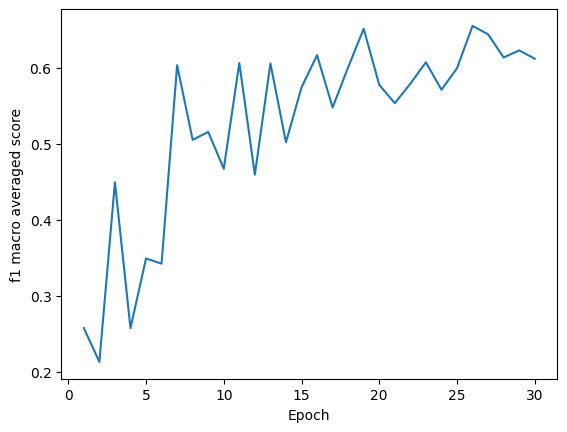

In [ ]:
plt.plot(range(1, epochs + 1), f1_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('f1 macro averaged score')
plt.show()

From the graph shown above, we can verify that the f1 macro averaged score reaches its maximum in the $26$th epoch out of the $30$ epochs tested.

What we can observe is that there is a decrease after the $26$th epoch until the $30$th epoch, which is most likely caused because of overfitting.

Test the best Neural Network on the test data.

In [ ]:
%%time
results = test_neural_network(test_dataloader, loss_function, best_model)

Test Error:
Avg loss               : 0.062293
f1 macro averaged score: 0.590420
Accuracy               : 61.6%
Confusion matrix       :
tensor([[255,  22,  18,   2],
        [ 39,  69, 145,  71],
        [ 24,  29, 295,   8],
        [ 46,  52,  72, 229]])
CPU times: user 46.5 ms, sys: 0 ns, total: 46.5 ms
Wall time: 47.6 ms


The best model yields slightly better results on the test dataset than the models used in **Step 4** and **Step 5**.
<br></br>

# Question 2 - Convolutional Neural Network

### Step 1 - Load data (mfccs)

Load train, test and validation data (spectrograms-melgrams).

In [ ]:
melgram_x_train = np.load('/content/music_genre_data_di/train/melgrams/X.npy')
melgram_y_train = np.load('/content/music_genre_data_di/train/melgrams/labels.npy')

melgram_x_test  = np.load('/content/music_genre_data_di/test/melgrams/X.npy')
melgram_y_test  = np.load('/content/music_genre_data_di/test/melgrams/labels.npy')

melgram_x_val   = np.load('/content/music_genre_data_di/val/melgrams/X.npy')
melgram_y_val   = np.load('/content/music_genre_data_di/val/melgrams/labels.npy')

Convert labels from strings <code>classical</code>, <code>blues</code>, <code>hiphop</code> and <code>rock_metal_hardrock</code> to integer values <code>0</code>, <code>1</code>, <code>2</code> and <code>3</code>.

In [ ]:
melgram_y_train = convert_labels(melgram_y_train)
melgram_y_test  = convert_labels(melgram_y_test)
melgram_y_val   = convert_labels(melgram_y_val)

Use Pytorch Dataloaders to load data into the Neural Network.

In [ ]:
train_dataloader = DataLoader(list(zip(melgram_x_train, melgram_y_train)), batch_size=16, shuffle=True)
test_dataloader  = DataLoader(list(zip(melgram_x_test, melgram_y_test)), batch_size=16, shuffle=True)
val_dataloader   = DataLoader(list(zip(melgram_x_val, melgram_y_val)), batch_size=16, shuffle=True)

Visualize a random melgram for each class.

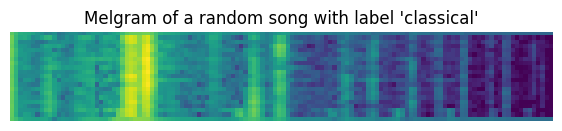

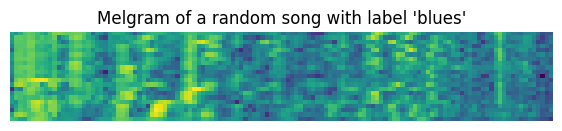

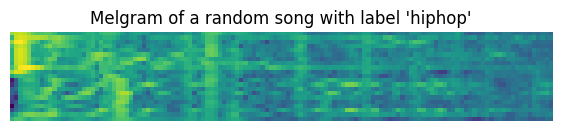

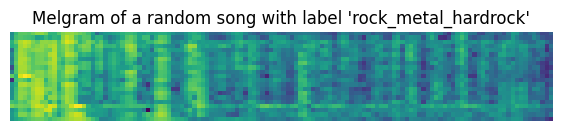

In [ ]:
# invert label dict
labels_int_to_str = dict(map(reversed, labels_str_to_int.items()))

melgrams_for_vis = []
while len(melgrams_for_vis) != 4:
  index = random.randint(0, 3200)
  # if haven't found a melgram with the same class as the random selected melgram
  if melgram_y_train[index] not in [data[1] for data in melgrams_for_vis]:
    # add it to list
    melgrams_for_vis.append((index, melgram_y_train[index]))

# sort list for better visualization
melgrams_for_vis = sorted(melgrams_for_vis, key=lambda x: x[1])
melgrams_indices = [data[0] for data in melgrams_for_vis]

for i, index in enumerate(melgrams_indices):
  melgram_x, melgram_y = melgram_x_train[index], melgram_y_train[index]
  plt.figure(figsize=(7, 5))
  plt.title(f'Melgram of a random song with label \'{labels_int_to_str[melgram_y_train[index]]}\'')
  plt.axis('off')
  plt.imshow(melgram_x)

### Step 2 - Definition of the Convolutional Neural Network

The Convolutional Neural Network that will be used consists of $4$ convolutional layers with kernel size $5$, so that the following channel (filter) sequence is taken: $1$, $16$, $32$, $64$ and $128$.

The output of the Convolutional Neural Network defined above should be considered as the input of a fully connected Neural Network that consists of $5$ layers with (cnn_out_dimensions), $1024$, $256$, $32$ and (out_dim) number of perceptrons respectively.

The first layer of the fully connected Neural Network is the input layer and it consists of $1024$ perceptrons, because the input size is $1024$.

The next three layers that consist of $1024$, $256$ and $32$ perceptrons respectively are the hidden layers.

The last layer is the output layer and it consists of $4$ perceptrons, because the number of different labels is $4$.
<br></br>

The code shown in compimentary courses has been modified in order to implement the Neural Network that was described above.

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)   # 1 channel   -> 16 channels
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)  # 16 channels -> 32 channels
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  # 32 channels -> 64 channels
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5) # 64 channels -> 128 channels

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = torch.flatten(x, 1)

    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.dense4(x)

    return x

### Step 3 - Training

Initialize model.

In [ ]:
cnn_model = Net().to(device)
print(cnn_model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)


Define the training procedure, similar to the training procedure that was used for the Neural Network in **Question 1**.

The code shown in compimentary courses has been modified in order to implement the training procedure was described above.

In [ ]:
def train_convolutional_neural_network(epochs, optimizer, dataloader, loss_function, model):
  size = len(dataloader.dataset)

  for epoch in range(0, epochs):
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1).type(torch.float))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print()

  return model

Define the testing procedure, similar to the testing procedure that was used for the Neural Network in **Question 1**.

The code shown in compimentary courses has been modified in order to implement the testing procedure was described above.

In [ ]:
def test_convolutional_neural_network(dataloader, loss_function, model):
  size = len(dataloader.dataset)
  test_loss, correct = 0, 0

  predictions = []
  labels = []
  with torch.no_grad():
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      predictions.append(prediction.argmax(1))
      test_loss += loss_function(prediction, y)
      correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

      # keep labels for later
      labels.append(y)

  test_loss /= size
  accuracy = 100 * (correct / size)
  predictions = torch.cat(predictions)
  labels = torch.cat(labels)
  f1_macro_avg = f1_score(predictions, labels, task='multiclass', num_classes=4, average='macro')

  # move confusion matrix to GPU if GPU is in use
  confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

  print("Test Error:")
  print(f"Avg loss               : {test_loss:>8f}")
  print(f"f1 macro averaged score: {f1_macro_avg:>8f}")
  print(f"Accuracy               : {accuracy:>0.1f}%")
  print(f"Confusion matrix       :")
  print(confusion_matrix(predictions, labels))

  return test_loss, f1_macro_avg, accuracy, confusion_matrix

Define the validation procedure, similar to the validation procedure that was used for the Neural Network in **Question 1**.

The code shown in compimentary courses has been modified in order to implement the validation procedure was described above.

In [ ]:
def validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model):
  size = len(train_dataloader.dataset)

  best = (0, 0, 0) # best model, best epoch, best f1 score
  f1_list = []

  for epoch in range(0, epochs):
    # train model with train data
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    for batch, (x, y) in enumerate(train_dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # test model on validation set
    results = test_convolutional_neural_network(val_dataloader, loss_function, model)
    f1_macro_avg = results[1]
    f1_list.append(f1_macro_avg)
    if f1_macro_avg > best[2]:
      best = (model, epoch, f1_macro_avg)
    print()

  print(f"Best epoch: {(best[1] + 1)} with f1 macro averaged score: {best[2]}")
  return best[0], f1_list

Train model using $learning$ $rate = 0.002$, Stochastic Gradient Descent optimizer and Cross Entropy Loss function for $30$ epochs, while keeping the best current f1 macro averaged score.

In [ ]:
learning_rate = 0.002
optimizer = SGD(params=cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

In [ ]:
cnn_model = train_convolutional_neural_network(epochs, optimizer, train_dataloader, loss_function, cnn_model)

Epoch: 1
-----------------------------


RuntimeError: ignored

The model cannot be trained.
<br></br>

The reason is that the output of the last convolutional layer has size $16 \times 71680$, where $16$ is the batch size and $71680$ is the length of the flattened data, that can be derived applying the following formula that has been shown in lectures for each layer:
<br></br>

$
\begin{aligned}
  & W_1 = \frac{W_0 - F - 2P}{S} + 1
\end{aligned}
$

$
\begin{aligned}
  & H_1 = \frac{H_0 - F - 2P}{S} + 1
\end{aligned}
$

$D_1 = K$, where:
<br></br>

$W_0 \times H_0 \times D_0$: volume that is accepted by the first convolutional layer

$K$: number of filters

$F$: spacial extent of the filters (kernel size)

$S$: stride

$P$: zero padding
<br></br>

$W_0 \times H_0 \times D_0 = 21 \times 128 \times 1$

layer $i$ | $K$   | $F$  | $S$  | $P$  | $W_i$ x $H_i$ x $D_i$ | flattened
:--------:|:-----:|:----:|:----:|:----:|:---------------------:|:----:
$1$       | $16$  | $5$  | $1$  | $0$  | $17$ x $124$ x $16$
$2$       | $32$  | $5$  | $1$  | $0$  | $13$ x $120$ x $32$
$3$       | $64$  | $5$  | $1$  | $0$  | $9$ x $116$ x $64$
$4$       | $128$ | $5$  | $1$  | $0$  | $5$ x $112$ x $128$   | $71680$

### Step 4 - Pooling and padding

Redefine the Convolutional Network Model by adding $P = 2$ to the filters and pooling layers with kernel size $2$.

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # 1 channel   -> 16 channels
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # 16 channels -> 32 channels
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # 32 channels -> 64 channels
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # 64 channels -> 128 channels

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = torch.flatten(x, 1)

    x = self.dense1(x)
    x = F.relu(x)
    x = self.dense2(x)
    x = F.relu(x)
    x = self.dense3(x)
    x = F.relu(x)
    x = self.dense4(x)

    return x

Initialize model.

In [ ]:
cnn_model = Net().to(device)
print(cnn_model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)


Train model using $learning$ $rate = 0.002$, Stochastic Gradient Descent optimizer and Cross Entropy Loss function for $30$ epochs, while keeping the best current f1 macro averaged score.

In [ ]:
learning_rate = 0.002
optimizer = SGD(params=cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

In [ ]:
%%time
cnn_model = train_convolutional_neural_network(epochs, optimizer, train_dataloader, loss_function, cnn_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.260114  [ 1200/ 3200]
loss: 1.040470  [ 1216/ 3200]
loss: 1.191701  [ 1232/ 3200]
loss: 1.208645  [ 1248/ 3200]
loss: 1.005197  [ 1264/ 3200]
loss: 1.390117  [ 1280/ 3200]
loss: 1.085066  [ 1296/ 3200]
loss: 1.120034  [ 1312/ 3200]
loss: 1.363739  [ 1328/ 3200]
loss: 1.098882  [ 1344/ 3200]
loss: 1.166921  [ 1360/ 3200]
loss: 1.022595  [ 1376/ 3200]
loss: 1.388696  [ 1392/ 3200]
loss: 1.320336  [ 1408/ 3200]
loss: 1.316082  [ 1424/ 3200]
loss: 1.271371  [ 1440/ 3200]
loss: 0.996496  [ 1456/ 3200]
loss: 1.155627  [ 1472/ 3200]
loss: 1.166157  [ 1488/ 3200]
loss: 1.195671  [ 1504/ 3200]
loss: 1.066227  [ 1520/ 3200]
loss: 1.203308  [ 1536/ 3200]
loss: 1.307122  [ 1552/ 3200]
loss: 1.265569  [ 1568/ 3200]
loss: 1.346875  [ 1584/ 3200]
loss: 1.187089  [ 1600/ 3200]
loss: 1.083877  [ 1616/ 3200]
loss: 1.263610  [ 1632/ 3200]
loss: 1.157002  [ 1648/ 3200]
loss: 1.439077  [ 1664/ 3200]
loss: 1.067971  [ 1680/ 3200]
loss: 1.033391 

Test our Convolutional Neural Network on the test data.

In [ ]:
%%time
results = test_convolutional_neural_network(test_dataloader, loss_function, cnn_model)

Test Error:
Avg loss               : 0.059207
f1 macro averaged score: 0.620641
Accuracy               : 62.0%
Confusion matrix       :
tensor([[163,  99,  32,   3],
        [  2, 214,  61,  47],
        [  1,  27, 309,  19],
        [  5, 117, 110, 167]], device='cuda:0')
CPU times: user 149 ms, sys: 4.47 ms, total: 153 ms
Wall time: 184 ms


Validation.

Initialize model.

In [ ]:
cnn_model = Net().to(device)
print(cnn_model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
learning_rate = 0.002
optimizer = SGD(params=cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

In [ ]:
%%time
best_model, f1_per_epoch = validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.311169  [ 1424/ 3200]
loss: 0.950143  [ 1440/ 3200]
loss: 0.911601  [ 1456/ 3200]
loss: 1.211442  [ 1472/ 3200]
loss: 1.284917  [ 1488/ 3200]
loss: 1.213743  [ 1504/ 3200]
loss: 1.159529  [ 1520/ 3200]
loss: 1.040693  [ 1536/ 3200]
loss: 1.174513  [ 1552/ 3200]
loss: 1.054895  [ 1568/ 3200]
loss: 1.368127  [ 1584/ 3200]
loss: 1.009333  [ 1600/ 3200]
loss: 1.193585  [ 1616/ 3200]
loss: 1.313507  [ 1632/ 3200]
loss: 1.044938  [ 1648/ 3200]
loss: 1.265589  [ 1664/ 3200]
loss: 0.948670  [ 1680/ 3200]
loss: 0.989446  [ 1696/ 3200]
loss: 1.072894  [ 1712/ 3200]
loss: 0.965374  [ 1728/ 3200]
loss: 0.907669  [ 1744/ 3200]
loss: 1.215414  [ 1760/ 3200]
loss: 0.959877  [ 1776/ 3200]
loss: 0.966269  [ 1792/ 3200]
loss: 0.879849  [ 1808/ 3200]
loss: 1.105601  [ 1824/ 3200]
loss: 0.971323  [ 1840/ 3200]
loss: 1.091528  [ 1856/ 3200]
loss: 0.834543  [ 1872/ 3200]
loss: 1.087493  [ 1888/ 3200]
loss: 0.842174  [ 1904/ 3200]
loss: 1.071032 

The best epoch for this execution is the $29$th.

Test the best Convolutional Neural Network on the test data.

In [ ]:
%%time
results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)

Test Error:
Avg loss               : 0.052765
f1 macro averaged score: 0.672850
Accuracy               : 66.8%
Confusion matrix       :
tensor([[229,  41,  19,   8],
        [ 12, 186,  65,  61],
        [  2,  26, 301,  27],
        [ 10,  92,  94, 203]], device='cuda:0')
CPU times: user 155 ms, sys: 4.05 ms, total: 159 ms
Wall time: 162 ms


Pooling is a technique used to reduce the feature map size, which also reduces the number of parameters that must be computed during the training procedure.

Max pooling keeps the features that are related to the the filter the most. [[2]](#reference)
<br></br>

Padding is used to control the reduction of the number of features, which can also be observed by the formula given in **Question 2 - Step 3**.

Padding can increase accuracy when analysing data in a Convolutional Neural Network.
[[3]](#reference)

### Step 5 - Optimization algorithms

We validate our Convolutional Neural Network for $30$ epochs and test it.

The optimizers used are the following: Adadelta, Adagrad, Adam, AdamW, Adamax, ASGD, NAdam, RAdam, RMSprop, Rprop and SGD.

In [ ]:
optimizers = {"Adadelta": Adadelta, "Adagrad": Adagrad, "Adam": Adam, "AdamW": AdamW, "Adamax": Adamax,
              "ASGD": ASGD, "NAdam": NAdam, "RAdam": RAdam, "RMSprop": RMSprop, "Rprop": Rprop, "SGD": SGD}

learning_rate = 0.002
loss_function = nn.CrossEntropyLoss()
epochs = 30

f1_accuracy = []
for opt, optimizer in optimizers.items():
  print("  Optimizer:", opt)
  cnn_model = Net().to(device)
  optimizer = optimizer(params=cnn_model.parameters(), lr=learning_rate)
  best_model, f1_per_epoch = validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model)
  results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
  f1_accuracy.append((opt, results[1], results[2]))
  print()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.083132  [ 1552/ 3200]
loss: 1.276684  [ 1568/ 3200]
loss: 1.222754  [ 1584/ 3200]
loss: 1.008696  [ 1600/ 3200]
loss: 1.195230  [ 1616/ 3200]
loss: 1.065974  [ 1632/ 3200]
loss: 1.057531  [ 1648/ 3200]
loss: 1.176192  [ 1664/ 3200]
loss: 0.922043  [ 1680/ 3200]
loss: 1.072480  [ 1696/ 3200]
loss: 1.173874  [ 1712/ 3200]
loss: 1.300763  [ 1728/ 3200]
loss: 0.943481  [ 1744/ 3200]
loss: 1.156795  [ 1760/ 3200]
loss: 1.094091  [ 1776/ 3200]
loss: 1.153724  [ 1792/ 3200]
loss: 1.142830  [ 1808/ 3200]
loss: 1.165508  [ 1824/ 3200]
loss: 1.024940  [ 1840/ 3200]
loss: 1.026091  [ 1856/ 3200]
loss: 1.047325  [ 1872/ 3200]
loss: 1.214421  [ 1888/ 3200]
loss: 1.302827  [ 1904/ 3200]
loss: 1.169886  [ 1920/ 3200]
loss: 1.044699  [ 1936/ 3200]
loss: 1.239419  [ 1952/ 3200]
loss: 0.853471  [ 1968/ 3200]
loss: 1.168366  [ 1984/ 3200]
loss: 1.245954  [ 2000/ 3200]
loss: 1.047333  [ 2016/ 3200]
loss: 0.917769  [ 2032/ 3200]
loss: 1.043424 

Execution time: $~5$ minutes.

Sort test results with the best Convolutional Model for each optimizer in decreasing order according to the f1 macro average score.

In [ ]:
f1_accuracy = sorted(f1_accuracy, key=lambda x: x[1], reverse=True)

print("Optimizer\tf1_macro_avg\tAccuracy")
for (opt, f1_macro_avg, accuracy) in f1_accuracy:
  if opt == 'Adadelta': # for better visualization
    print(f"{opt}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
    continue
  print(f"{opt}\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

Optimizer	f1_macro_avg	Accuracy
Adagrad		0.750259	74.273256
Adamax		0.730673	73.037791
AdamW		0.688723	69.404070
RMSprop		0.676906	68.168605
Adam		0.670797	66.279070
NAdam		0.669163	66.061047
SGD		0.658436	66.351744
RAdam		0.636210	66.133721
Rprop		0.620761	61.627907
ASGD		0.612188	61.845930
Adadelta	0.551784	53.924419


The table above shows that the optimizer plays a big role in the development of the model, since it can really change the results during testing.

The best optimizer for our Convolutional Neural Network was Adagrad with $74\%$ accuracy and the worst was Adadelta with $53\%$ accuracy.

# Question 3 - Improving Performance

### Step 1 - Reproducibility

Seed all libraries and algorithms, so that the model is deterministic.

In [37]:
def torch_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONASHSEED'] = str(seed)

def set_epoch(self, epoch):
  self.epoch = epoch
  self.generator.manual_seed(0 + self.epoch)

Repeat **Step 1**.

In [38]:
melgram_x_train = np.load('/content/music_genre_data_di/train/melgrams/X.npy')
melgram_y_train = np.load('/content/music_genre_data_di/train/melgrams/labels.npy')

melgram_x_test  = np.load('/content/music_genre_data_di/test/melgrams/X.npy')
melgram_y_test  = np.load('/content/music_genre_data_di/test/melgrams/labels.npy')

melgram_x_val   = np.load('/content/music_genre_data_di/val/melgrams/X.npy')
melgram_y_val   = np.load('/content/music_genre_data_di/val/melgrams/labels.npy')

melgram_y_train = convert_labels(melgram_y_train)
melgram_y_test  = convert_labels(melgram_y_test)
melgram_y_val   = convert_labels(melgram_y_val)

train_dataloader = DataLoader(list(zip(melgram_x_train, melgram_y_train)), batch_size=16, shuffle=True, generator=torch.Generator(device='cpu'))
train_dataloader.set_epoch = set_epoch

test_dataloader  = DataLoader(list(zip(melgram_x_test, melgram_y_test)), batch_size=16, shuffle=True, generator=torch.Generator(device='cpu'))
test_dataloader.set_epoch = set_epoch

val_dataloader   = DataLoader(list(zip(melgram_x_val, melgram_y_val)), batch_size=16, shuffle=True, generator=torch.Generator(device='cpu'))
val_dataloader.set_epoch = set_epoch

Redefine the Convolutional Neural Network (same code as in **Step 4**).

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # 1 channel   -> 16 channels
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # 16 channels -> 32 channels
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # 32 channels -> 64 channels
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # 64 channels -> 128 channels

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = torch.flatten(x, 1)

    x = self.dense1(x)
    x = F.relu(x)
    x = self.dense2(x)
    x = F.relu(x)
    x = self.dense3(x)
    x = F.relu(x)
    x = self.dense4(x)

    return x

Redefine the training, testing and validation procedure in order to make the model reproducible.

In [ ]:
def train_convolutional_neural_network(epochs, optimizer, dataloader, loss_function, model, reproducibility=False):
  size = len(dataloader.dataset)

  for epoch in range(0, epochs):
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    if reproducibility: # added
      dataloader.set_epoch(dataloader, epoch)
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1).type(torch.float))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print()

  return model

In [35]:
def test_convolutional_neural_network(dataloader, loss_function, model):
  size = len(dataloader.dataset)
  test_loss, correct = 0, 0

  predictions = []
  labels = []
  with torch.no_grad():
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      predictions.append(prediction.argmax(1))
      test_loss += loss_function(prediction, y)
      correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

      # keep labels for later
      labels.append(y)

  test_loss /= size
  accuracy = 100 * (correct / size)
  predictions = torch.cat(predictions)
  labels = torch.cat(labels)
  f1_macro_avg = f1_score(predictions, labels, task='multiclass', num_classes=4, average='macro')

  # move confusion matrix to GPU if GPU is in use
  confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
  print("Test Error:")
  print(f"Avg loss               : {test_loss:>8f}")
  print(f"f1 macro averaged score: {f1_macro_avg:>8f}")
  print(f"Accuracy               : {accuracy:>0.1f}%")
  print(f"Confusion matrix       :")
  print(confusion_matrix(predictions, labels))

  return test_loss, f1_macro_avg, accuracy, confusion_matrix

In [ ]:
def validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model, reproducibility):
  size = len(train_dataloader.dataset)

  best = (0, 0, 0) # best model, best epoch, best f1 score
  f1_list = []

  for epoch in range(0, epochs):
    # train model with train data
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    if reproducibility: # added
      train_dataloader.set_epoch(train_dataloader, epoch)
    for batch, (x, y) in enumerate(train_dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # test model on validation set
    results = test_convolutional_neural_network(val_dataloader, loss_function, model)
    f1_macro_avg = results[1]
    f1_list.append(f1_macro_avg)
    if f1_macro_avg > best[2]:
      best = (model, epoch, f1_macro_avg)
    print()

  print(f"Best epoch: {(best[1] + 1)} with f1 macro averaged score: {best[2]}")
  return best[0], f1_list

Test the seeding done above, by training the model twice.

Results should now be the same.

In [ ]:
torch_seed(0)
cnn_model = Net().to(device)

learning_rate = 0.002
optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

cnn_model = train_convolutional_neural_network(epochs, optimizer, train_dataloader, loss_function, cnn_model, True)
results = test_convolutional_neural_network(test_dataloader, loss_function, cnn_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.772601  [ 1312/ 3200]
loss: 0.603267  [ 1328/ 3200]
loss: 0.389988  [ 1344/ 3200]
loss: 0.312300  [ 1360/ 3200]
loss: 0.649883  [ 1376/ 3200]
loss: 0.402415  [ 1392/ 3200]
loss: 0.379302  [ 1408/ 3200]
loss: 0.487795  [ 1424/ 3200]
loss: 0.817650  [ 1440/ 3200]
loss: 0.879129  [ 1456/ 3200]
loss: 0.573630  [ 1472/ 3200]
loss: 0.795514  [ 1488/ 3200]
loss: 0.538295  [ 1504/ 3200]
loss: 0.242006  [ 1520/ 3200]
loss: 0.562402  [ 1536/ 3200]
loss: 0.397960  [ 1552/ 3200]
loss: 0.680610  [ 1568/ 3200]
loss: 0.461949  [ 1584/ 3200]
loss: 0.516605  [ 1600/ 3200]
loss: 0.414831  [ 1616/ 3200]
loss: 0.348879  [ 1632/ 3200]
loss: 0.289238  [ 1648/ 3200]
loss: 0.464025  [ 1664/ 3200]
loss: 0.299047  [ 1680/ 3200]
loss: 0.517515  [ 1696/ 3200]
loss: 0.367538  [ 1712/ 3200]
loss: 0.354482  [ 1728/ 3200]
loss: 0.381026  [ 1744/ 3200]
loss: 0.514871  [ 1760/ 3200]
loss: 0.283617  [ 1776/ 3200]
loss: 0.847765  [ 1792/ 3200]
loss: 0.800440 

In [ ]:
torch_seed(0)
cnn_model = Net().to(device)

learning_rate = 0.002
optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
epochs = 30

cnn_model = train_convolutional_neural_network(epochs, optimizer, train_dataloader, loss_function, cnn_model, True)
results = test_convolutional_neural_network(test_dataloader, loss_function, cnn_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.772601  [ 1312/ 3200]
loss: 0.603267  [ 1328/ 3200]
loss: 0.389988  [ 1344/ 3200]
loss: 0.312300  [ 1360/ 3200]
loss: 0.649883  [ 1376/ 3200]
loss: 0.402415  [ 1392/ 3200]
loss: 0.379302  [ 1408/ 3200]
loss: 0.487795  [ 1424/ 3200]
loss: 0.817650  [ 1440/ 3200]
loss: 0.879129  [ 1456/ 3200]
loss: 0.573630  [ 1472/ 3200]
loss: 0.795514  [ 1488/ 3200]
loss: 0.538295  [ 1504/ 3200]
loss: 0.242006  [ 1520/ 3200]
loss: 0.562402  [ 1536/ 3200]
loss: 0.397960  [ 1552/ 3200]
loss: 0.680610  [ 1568/ 3200]
loss: 0.461949  [ 1584/ 3200]
loss: 0.516605  [ 1600/ 3200]
loss: 0.414831  [ 1616/ 3200]
loss: 0.348879  [ 1632/ 3200]
loss: 0.289238  [ 1648/ 3200]
loss: 0.464025  [ 1664/ 3200]
loss: 0.299047  [ 1680/ 3200]
loss: 0.517515  [ 1696/ 3200]
loss: 0.367538  [ 1712/ 3200]
loss: 0.354482  [ 1728/ 3200]
loss: 0.381026  [ 1744/ 3200]
loss: 0.514871  [ 1760/ 3200]
loss: 0.283617  [ 1776/ 3200]
loss: 0.847765  [ 1792/ 3200]
loss: 0.800440 

We can verify that the two models have the same loss for each pair of batch and epoch during training and yield the exact same results during testing.

### Step 2 - Activation functions

Redefine the Convolutional Neural Network, so that the activation function can be given as an argument and be used in <code>forward()</code> instead of ReLU.

In [ ]:
class Net(nn.Module):
  def __init__(self, activation_function):
    super().__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # 1 channel   -> 16 channels
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # 16 channels -> 32 channels
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # 32 channels -> 64 channels
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # 64 channels -> 128 channels

    self.activation_function = activation_function()

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = torch.flatten(x, 1)

    x = self.dense1(x)
    x = self.activation_function(x)
    x = self.dense2(x)
    x = self.activation_function(x)
    x = self.dense3(x)
    x = self.activation_function(x)
    x = self.dense4(x)

    return x

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses the Adagrad optimizer, as stated in the previous steps.

The activation functions used are the following: ELU, Hardshrink, Hardsigmoid, Hardtanh, Hardswish, LeakyReLU, LogSigmoid, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, GELU, Sigmoid, SiLU, Mish, Softplus, Softshrink, Softsign, Tanh, Tanhshrink.

In [ ]:
%%time
activation_functions = {"ELU": ELU, "Hardshrink": Hardshrink, "Hardsigmoid": Hardsigmoid, "Hardtanh": Hardtanh, "Hardswish": Hardswish,
                        "LeakyReLU": LeakyReLU, "LogSigmoid": LogSigmoid,
                        "PReLU": PReLU, "ReLU": ReLU, "ReLU6": ReLU6, "RReLU": RReLU, "SELU": SELU, "CELU": CELU, "GELU": GELU,
                        "Sigmoid": Sigmoid, "SiLU": SiLU, "Mish": Mish, "Softplus": Softplus, "Softshrink": Softshrink, "Softsign": Softsign,
                        "Tanh": Tanh, "Tanhshrink": Tanhshrink}

learning_rate = 0.002
loss_function = nn.CrossEntropyLoss()
epochs = 30

f1_accuracy = []
for act, activation_function in activation_functions.items():
  print("  Activation function:", act)
  torch_seed(0)
  cnn_model = Net(activation_function).to(device)
  optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate)
  best_model, f1_per_epoch = validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True)
  results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
  f1_accuracy.append((act, results[1], results[2]))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.431832  [ 1568/ 3200]
loss: 1.383111  [ 1584/ 3200]
loss: 1.402261  [ 1600/ 3200]
loss: 1.353530  [ 1616/ 3200]
loss: 1.374574  [ 1632/ 3200]
loss: 1.375576  [ 1648/ 3200]
loss: 1.390301  [ 1664/ 3200]
loss: 1.375280  [ 1680/ 3200]
loss: 1.394672  [ 1696/ 3200]
loss: 1.414776  [ 1712/ 3200]
loss: 1.382787  [ 1728/ 3200]
loss: 1.369140  [ 1744/ 3200]
loss: 1.405612  [ 1760/ 3200]
loss: 1.414398  [ 1776/ 3200]
loss: 1.398048  [ 1792/ 3200]
loss: 1.388941  [ 1808/ 3200]
loss: 1.377401  [ 1824/ 3200]
loss: 1.391904  [ 1840/ 3200]
loss: 1.389728  [ 1856/ 3200]
loss: 1.402747  [ 1872/ 3200]
loss: 1.395945  [ 1888/ 3200]
loss: 1.410254  [ 1904/ 3200]
loss: 1.406414  [ 1920/ 3200]
loss: 1.359241  [ 1936/ 3200]
loss: 1.380731  [ 1952/ 3200]
loss: 1.387135  [ 1968/ 3200]
loss: 1.364876  [ 1984/ 3200]
loss: 1.388739  [ 2000/ 3200]
loss: 1.384979  [ 2016/ 3200]
loss: 1.387516  [ 2032/ 3200]
loss: 1.392961  [ 2048/ 3200]
loss: 1.379023 

In [ ]:
f1_accuracy = sorted(f1_accuracy, key=lambda x: x[1], reverse=True)

print("Act function\tf1_macro_avg\tAccuracy")
for (act_function, f1_macro_avg, accuracy) in f1_accuracy:
  if len(act_function) > 7: # for better visualization
    print(f"{act_function}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
    continue
  print(f"{act_function}\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

Act function	f1_macro_avg	Accuracy
ELU		0.780637	77.761628
CELU		0.780637	77.761628
SELU		0.775539	77.180233
Softplus	0.756048	75.872093
ReLU6		0.745794	74.200581
RReLU		0.745444	74.127907
GELU		0.744725	74.055233
Hardswish	0.744151	74.273256
PReLU		0.743645	73.982558
ReLU		0.742370	73.546512
Hardshrink	0.742286	74.127907
Softsign	0.741381	73.546512
LeakyReLU	0.740447	73.401163
Mish		0.739895	73.619186
Tanh		0.739474	73.764535
Tanhshrink	0.738403	74.345930
LogSigmoid	0.735301	73.473837
SiLU		0.735135	73.110465
Sigmoid		0.542419	59.520349
Hardsigmoid	0.531221	55.813953
Softshrink	0.095294	23.546512
Hardtanh	0.088763	21.584302


The table above shows that the optimizer plays a big role in the development of the model, since it can really change the results during testing.

The best activation function for our Convolutional Neural Network was ELU with $77\%$ accuracy and the worst was Hardtanh with $21\%$ accuracy.
<br></br>

We conclude that ELU increased accuracy from $74\%$ to $77\%$.

### Step 3 - Learning Rate Scheduler

Redefine the training and validation procedure, so that the learning rate scheduler can be given as an argument.

In [ ]:
def train_convolutional_neural_network(epochs, optimizer, dataloader, loss_function, model, reproducibility=False, scheduler=None):
  size = len(dataloader.dataset)

  for epoch in range(0, epochs):
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    if reproducibility: # added in Question 3 - Step 1
      dataloader.set_epoch(dataloader, epoch)
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1).type(torch.float))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # adjust learning rate
    scheduler.step()
    print()

  return model

In [ ]:
def validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model, reproducibility, scheduler):
  size = len(train_dataloader.dataset)

  best = (0, 0, 0) # best model, best epoch, best f1 score
  f1_list = []

  for epoch in range(0, epochs):
    # train model with train data
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    if reproducibility: # added
      train_dataloader.set_epoch(train_dataloader, epoch)
    for batch, (x, y) in enumerate(train_dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # test model on validation set
    results = test_convolutional_neural_network(val_dataloader, loss_function, model)
    f1_macro_avg = results[1]
    f1_list.append(f1_macro_avg)
    if f1_macro_avg > best[2]:
      best = (model, epoch, f1_macro_avg)

    # adjust learning rate
    scheduler.step()
    print()

  print(f"Best epoch: {(best[1] + 1)} with f1 macro averaged score: {best[2]}")
  return best[0], f1_list

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses the Adagrad optimizer and the ELU activation function, as stated in the previous steps.

The schedulers used are the following: LambdaLR, MultiplicativeLR, StepLR, MultiStepLR, ConstantLR, LinearLR, ExponentialLR, PolynomialLR, CyclicLR.

In [ ]:
%%time
learning_rate_0 = 0.002
loss_function = nn.CrossEntropyLoss()
epochs = 30

# lr_lambda, step_size, gamma etc. argument values are taken from examples found in Pytorch Documentation pages for each scheduler
def get_scheduler(index, optimizer):
  if index == 0:
    return "LambdaLR", LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: epoch // 30, verbose=True)
  elif index == 1:
    return "MultiplicativeLR", MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
  elif index == 2:
    return "StepLR", StepLR(optimizer=optimizer, step_size=30, gamma=0.1, verbose=True)
  elif index == 3:
    return "MultiStepLR", MultiStepLR(optimizer=optimizer, milestones=[30,80], gamma=0.1, verbose=True)
  elif index == 4:
    return "ConstantLR", ConstantLR(optimizer=optimizer, factor=0.5, total_iters=4, verbose=True)
  elif index == 5:
    return "LinearLR", LinearLR(optimizer=optimizer, start_factor=0.5, total_iters=4, verbose=True)
  elif index == 6:
    return "ExponentialLR", ExponentialLR(optimizer=optimizer, gamma=0.1, verbose=True)
  elif index == 7:
    return "PolynomialLR", PolynomialLR(optimizer=optimizer, total_iters=4, power=2.0, verbose=True)
  else:
    return "CyclicLR", CyclicLR(optimizer=optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False, verbose=True)

f1_accuracy = []
for i in range(0, 9):
  torch_seed(0)
  cnn_model = Net(ELU).to(device)
  optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0)
  sch, scheduler = get_scheduler(i, optimizer)
  print("  Scheduler:", sch)
  best_model, f1_per_epoch = validate_convolutional_neural_network(
      epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
      )
  results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
  f1_accuracy.append((sch, results[1], results[2]))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.599710  [ 1952/ 3200]
loss: 0.526369  [ 1968/ 3200]
loss: 0.464395  [ 1984/ 3200]
loss: 0.362512  [ 2000/ 3200]
loss: 0.613904  [ 2016/ 3200]
loss: 0.617890  [ 2032/ 3200]
loss: 0.458244  [ 2048/ 3200]
loss: 0.277873  [ 2064/ 3200]
loss: 0.300713  [ 2080/ 3200]
loss: 0.579099  [ 2096/ 3200]
loss: 0.473885  [ 2112/ 3200]
loss: 0.879033  [ 2128/ 3200]
loss: 0.723749  [ 2144/ 3200]
loss: 0.414537  [ 2160/ 3200]
loss: 0.563259  [ 2176/ 3200]
loss: 0.684590  [ 2192/ 3200]
loss: 0.789107  [ 2208/ 3200]
loss: 0.329238  [ 2224/ 3200]
loss: 0.605539  [ 2240/ 3200]
loss: 0.820574  [ 2256/ 3200]
loss: 0.974448  [ 2272/ 3200]
loss: 0.651306  [ 2288/ 3200]
loss: 0.435579  [ 2304/ 3200]
loss: 0.704582  [ 2320/ 3200]
loss: 0.826604  [ 2336/ 3200]
loss: 0.918709  [ 2352/ 3200]
loss: 0.537012  [ 2368/ 3200]
loss: 0.541867  [ 2384/ 3200]
loss: 0.925720  [ 2400/ 3200]
loss: 0.743056  [ 2416/ 3200]
loss: 0.338515  [ 2432/ 3200]
loss: 0.491163 

In [ ]:
f1_accuracy = sorted(f1_accuracy, key=lambda x: x[1], reverse=True)

print("Scheduler\t\tf1_macro_avg\tAccuracy")
for (scheduler, f1_macro_avg, accuracy) in f1_accuracy:
  if len(scheduler) > 14: # for better visualization
    print(f"{scheduler}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
    continue
  if len(scheduler) > 7:  # for better visualization
    print(f"{scheduler}\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
    continue
  print(f"{scheduler}\t\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

Scheduler		f1_macro_avg	Accuracy
MultiplicativeLR	0.781785	77.906977
StepLR			0.780637	77.761628
MultiStepLR		0.780637	77.761628
CyclicLR		0.766720	76.526163
LinearLR		0.751379	74.709302
ConstantLR		0.751224	74.709302
PolynomialLR		0.726837	72.529070
ExponentialLR		0.643599	66.206395
LambdaLR		0.095294	23.546512


The table above shows that the optimizer plays a big role in the development of the model, since it can really change the results during testing.

The best activation function for our Convolutional Neural Network was ELU with almost $78\%$ accuracy and the worst was Hardtanh with $23\%$ accuracy.
<br></br>

We conclude that MultiplicativeLR increased accuracy from $77\%$ to $78\%$.

### Step 4 - Batch Normalization

Redefine the Convolutional Network Model by adding batch normalization layers.

In [ ]:
class Net(nn.Module):
  def __init__(self, activation_function):
    super().__init__()
    # convolutional layers
    self.conv1_batch_norm = nn.BatchNorm2d(1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # 1 channel   -> 16 channels
    self.conv2_batch_norm = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # 16 channels -> 32 channels
    self.conv3_batch_norm = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # 32 channels -> 64 channels
    self.conv4_batch_norm = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # 64 channels -> 128 channels

    self.activation_function = activation_function()

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = torch.flatten(x, 1)

    x = self.dense1(x)
    x = self.activation_function(x)
    x = self.dense2(x)
    x = self.activation_function(x)
    x = self.dense3(x)
    x = self.activation_function(x)
    x = self.dense4(x)

    return x

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler

as stated in the previous steps.

In [ ]:
%%time
torch_seed(0)
cnn_model = Net(ELU).to(device)

learning_rate = 0.002
optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate)
scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
loss_function = nn.CrossEntropyLoss()
epochs = 30

best_model, f1_per_epoch = validate_convolutional_neural_network(
      epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
      )
results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.275193  [ 1952/ 3200]
loss: 0.344462  [ 1968/ 3200]
loss: 0.173467  [ 1984/ 3200]
loss: 0.247901  [ 2000/ 3200]
loss: 0.256229  [ 2016/ 3200]
loss: 0.467592  [ 2032/ 3200]
loss: 0.224782  [ 2048/ 3200]
loss: 0.198767  [ 2064/ 3200]
loss: 0.155372  [ 2080/ 3200]
loss: 0.457266  [ 2096/ 3200]
loss: 0.215905  [ 2112/ 3200]
loss: 0.474478  [ 2128/ 3200]
loss: 0.415050  [ 2144/ 3200]
loss: 0.268733  [ 2160/ 3200]
loss: 0.387448  [ 2176/ 3200]
loss: 0.218260  [ 2192/ 3200]
loss: 0.345116  [ 2208/ 3200]
loss: 0.239158  [ 2224/ 3200]
loss: 0.501732  [ 2240/ 3200]
loss: 0.771184  [ 2256/ 3200]
loss: 1.107691  [ 2272/ 3200]
loss: 0.499292  [ 2288/ 3200]
loss: 0.295326  [ 2304/ 3200]
loss: 0.543614  [ 2320/ 3200]
loss: 0.475257  [ 2336/ 3200]
loss: 0.452445  [ 2352/ 3200]
loss: 0.432226  [ 2368/ 3200]
loss: 0.312425  [ 2384/ 3200]
loss: 0.606847  [ 2400/ 3200]
loss: 0.578857  [ 2416/ 3200]
loss: 0.252839  [ 2432/ 3200]
loss: 0.423132 

The accuracy stayed the same, around almost $78\%$.

### Step 5 - Regularization

i) Weight decay

The following function validates a Convolutional Neural Network for different values of weight decay.

In [ ]:
def validate_weight_decay(weight_decay_list, epochs):
  f1_accuracy = []
  for weight_decay in weight_decay_list:
    torch_seed(0)
    cnn_model = Net(ELU).to(device)
    optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0, weight_decay=weight_decay)
    scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
    print("  Weight decay:", weight_decay)
    best_model, f1_per_epoch = validate_convolutional_neural_network(
        epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
        )
    results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
    f1_accuracy.append((weight_decay, results[1], results[2]))
  return f1_accuracy

We validate our Convolutional Neural Network for $30$ and $60$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization

as stated in the previous steps.

The weight decay values used are the following: $0$, $10^{-5}$, $10^{-4}$, $10^{-3}$, $10^{-2}$, $10^{-1}$ and $1$.

In [ ]:
%%time
weight_decay_list = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

f1_accuracy_30 = validate_weight_decay(weight_decay_list, 30)
f1_accuracy_60 = validate_weight_decay(weight_decay_list, 60)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.384530  [ 1952/ 3200]
loss: 1.388224  [ 1968/ 3200]
loss: 1.388724  [ 1984/ 3200]
loss: 1.381238  [ 2000/ 3200]
loss: 1.381717  [ 2016/ 3200]
loss: 1.385049  [ 2032/ 3200]
loss: 1.385666  [ 2048/ 3200]
loss: 1.389686  [ 2064/ 3200]
loss: 1.382332  [ 2080/ 3200]
loss: 1.382218  [ 2096/ 3200]
loss: 1.386395  [ 2112/ 3200]
loss: 1.390460  [ 2128/ 3200]
loss: 1.385414  [ 2144/ 3200]
loss: 1.387857  [ 2160/ 3200]
loss: 1.384935  [ 2176/ 3200]
loss: 1.390938  [ 2192/ 3200]
loss: 1.385278  [ 2208/ 3200]
loss: 1.388610  [ 2224/ 3200]
loss: 1.390091  [ 2240/ 3200]
loss: 1.383955  [ 2256/ 3200]
loss: 1.387470  [ 2272/ 3200]
loss: 1.378660  [ 2288/ 3200]
loss: 1.390938  [ 2304/ 3200]
loss: 1.385437  [ 2320/ 3200]
loss: 1.390049  [ 2336/ 3200]
loss: 1.388608  [ 2352/ 3200]
loss: 1.388722  [ 2368/ 3200]
loss: 1.387239  [ 2384/ 3200]
loss: 1.387286  [ 2400/ 3200]
loss: 1.389587  [ 2416/ 3200]
loss: 1.386874  [ 2432/ 3200]
loss: 1.389494 

In [ ]:
f1_accuracy_30 = sorted(f1_accuracy_30, key=lambda x: x[1], reverse=True)
f1_accuracy_60 = sorted(f1_accuracy_60, key=lambda x: x[1], reverse=True)

print("30 epochs")
print("W Decay\tf1_macro_avg\tAccuracy")
for (weight_decay, f1_macro_avg, accuracy) in f1_accuracy_30:
  print(f"{weight_decay}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
print()

print("60 epochs")
print("W Decay\tf1_macro_avg\tAccuracy")
for (weight_decay, f1_macro_avg, accuracy) in f1_accuracy_60:
  print(f"{weight_decay}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

30 epochs
W Decay	f1_macro_avg	Accuracy
0	0.781785	77.906977
1e-05	0.777850	77.543605
0.001	0.775723	77.398256
0.0001	0.773398	77.034884
0.01	0.770161	77.107558
0.1	0.153741	28.488372
1	0.095294	23.546512

60 epochs
W Decay	f1_macro_avg	Accuracy
0.01	0.783624	78.052326
0	0.779698	77.616279
0.001	0.777604	77.470930
1e-05	0.772178	76.816860
0.0001	0.764765	76.017442
0.1	0.166500	29.433140
1	0.095294	23.546512


When using only weight decay $0.01 = 1e-2$ for $60$ epochs, the accuracy exceeded $78\%$.

ii) Dropout

Redefine the Convolutional Neural Network, so that the dropout parameter is given as an argument during initialization.

In [33]:
class Net(nn.Module):
  def __init__(self, activation_function, p):
    super().__init__()
    # convolutional layers
    self.conv1_batch_norm = nn.BatchNorm2d(1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)   # 1 channel   -> 16 channels
    self.conv2_batch_norm = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)  # 16 channels -> 32 channels
    self.conv3_batch_norm = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  # 32 channels -> 64 channels
    self.conv4_batch_norm = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # 64 channels -> 128 channels

    self.activation_function = activation_function()
    self.dropout = nn.Dropout(p)

    # fully connected (dense) layers
    self.dense1 = nn.Linear(1024, 1024) # input size = 1024 -> number of perceptrons in 1st hidden layer = 1024
    self.dense2 = nn.Linear(1024, 256)  # number of perceptrons in 1st hidden layer = 1024 ->
                                        # number of perceptrons in 2nd hidden layer = 256
    self.dense3 = nn.Linear(256, 32)    # number of perceptrons in 2nd hidden layer = 256 ->
                                        # number of perceptrons in 3rd hidden layer = 32
    self.dense4 = nn.Linear(32, 4)      # number of perceptrons in 3rd hidden layer = 32 ->
                                        # number of different labels = 4

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv4(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x, kernel_size=2)

    x = torch.flatten(x, 1)

    x = self.dropout(x)
    x = self.dense1(x)
    x = self.activation_function(x)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.activation_function(x)
    x = self.dropout(x)
    x = self.dense3(x)
    x = self.activation_function(x)
    x = self.dropout(x)
    x = self.dense4(x)

    return x

The following function validates a Convolutional Neural Network for different values of dropout.

In [ ]:
def validate_dropout(p_list, epochs):
  f1_accuracy = []
  for p in p_list:
    torch_seed(0)
    cnn_model = Net(ELU, p).to(device)
    optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0)
    scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
    print("  Dropout     :", p)
    best_model, f1_per_epoch = validate_convolutional_neural_network(
        epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
        )
    results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
    f1_accuracy.append((p, results[1], results[2]))
  return f1_accuracy

We validate our Convolutional Neural Network for $30$ and $60$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization

as stated in the previous steps.

The dropout values used are the following: $0.1$, $0.2$ and $0.3$.

In [ ]:
%%time
p_list = [0.1, 0.2, 0.3]

f1_accuracy_30 = validate_dropout(p_list, 30)
f1_accuracy_60 = validate_dropout(p_list, 60)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.021861  [ 1952/ 3200]
loss: 0.084081  [ 1968/ 3200]
loss: 0.036613  [ 1984/ 3200]
loss: 0.170455  [ 2000/ 3200]
loss: 0.031585  [ 2016/ 3200]
loss: 0.085423  [ 2032/ 3200]
loss: 0.019172  [ 2048/ 3200]
loss: 0.085060  [ 2064/ 3200]
loss: 0.097388  [ 2080/ 3200]
loss: 0.038620  [ 2096/ 3200]
loss: 0.058712  [ 2112/ 3200]
loss: 0.051209  [ 2128/ 3200]
loss: 0.046714  [ 2144/ 3200]
loss: 0.009988  [ 2160/ 3200]
loss: 0.062783  [ 2176/ 3200]
loss: 0.072234  [ 2192/ 3200]
loss: 0.018341  [ 2208/ 3200]
loss: 0.058367  [ 2224/ 3200]
loss: 0.245929  [ 2240/ 3200]
loss: 0.042253  [ 2256/ 3200]
loss: 0.038929  [ 2272/ 3200]
loss: 0.086000  [ 2288/ 3200]
loss: 0.025298  [ 2304/ 3200]
loss: 0.019068  [ 2320/ 3200]
loss: 0.105643  [ 2336/ 3200]
loss: 0.198647  [ 2352/ 3200]
loss: 0.051258  [ 2368/ 3200]
loss: 0.077262  [ 2384/ 3200]
loss: 0.055280  [ 2400/ 3200]
loss: 0.023678  [ 2416/ 3200]
loss: 0.513010  [ 2432/ 3200]
loss: 0.048682 

In [ ]:
f1_accuracy_30 = sorted(f1_accuracy_30, key=lambda x: x[1], reverse=True)
f1_accuracy_60 = sorted(f1_accuracy_60, key=lambda x: x[1], reverse=True)

print("30 epochs")
print("Dropout\tf1_macro_avg\tAccuracy")
for (dropout, f1_macro_avg, accuracy) in f1_accuracy_30:
  print(f"{dropout}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
print()

print("60 epochs")
print("Dropout\tf1_macro_avg\tAccuracy")
for (dropout, f1_macro_avg, accuracy) in f1_accuracy_60:
  print(f"{dropout}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

30 epochs
Dropout	f1_macro_avg	Accuracy
0.3	0.785990	78.488372
0.1	0.785191	78.343023
0.2	0.771558	76.962209

60 epochs
Dropout	f1_macro_avg	Accuracy
0.1	0.783522	77.834302
0.2	0.776003	77.325581
0.3	0.775903	77.180233


When using only dropout $0.1$ for $30$ epochs, the accuracy is increased to almost $78.5\%$.

i) Weight decay and ii) Dropout

The following function validates a Convolutional Neural Network for different values of weight decay and dropout.

In [ ]:
def validate_weight_decay_dropout(weight_decay_list, p_list, epochs):
  f1_accuracy = []
  for weight_decay in weight_decay_list:
    for p in p_list:
      torch_seed(0)
      cnn_model = Net(ELU, p).to(device)
      optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0, weight_decay=weight_decay)
      scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
      print("  Weight decay:", weight_decay)
      print("  Dropout     :", p)
      best_model, f1_per_epoch = validate_convolutional_neural_network(
          epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
          )
      results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
      f1_accuracy.append((weight_decay, p, results[1], results[2]))
  return f1_accuracy

We validate our Convolutional Neural Network for $30$ and $60$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization

as stated in the previous steps.

The weight decay and dropout values are the same as before, except the fact that now we are trying to find the optimal combination.

In [ ]:
%%time
weight_decay_list = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
p_list = [0.1, 0.2, 0.3]

f1_accuracy_30 = validate_weight_decay_dropout(weight_decay_list, p_list, 30)
f1_accuracy_60 = validate_weight_decay_dropout(weight_decay_list, p_list, 60)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 1.384473  [ 1952/ 3200]
loss: 1.388189  [ 1968/ 3200]
loss: 1.388715  [ 1984/ 3200]
loss: 1.381229  [ 2000/ 3200]
loss: 1.381688  [ 2016/ 3200]
loss: 1.385062  [ 2032/ 3200]
loss: 1.385709  [ 2048/ 3200]
loss: 1.389639  [ 2064/ 3200]
loss: 1.382332  [ 2080/ 3200]
loss: 1.382215  [ 2096/ 3200]
loss: 1.386395  [ 2112/ 3200]
loss: 1.390459  [ 2128/ 3200]
loss: 1.385408  [ 2144/ 3200]
loss: 1.387844  [ 2160/ 3200]
loss: 1.384947  [ 2176/ 3200]
loss: 1.390916  [ 2192/ 3200]
loss: 1.385297  [ 2208/ 3200]
loss: 1.388598  [ 2224/ 3200]
loss: 1.390112  [ 2240/ 3200]
loss: 1.383960  [ 2256/ 3200]
loss: 1.387431  [ 2272/ 3200]
loss: 1.378685  [ 2288/ 3200]
loss: 1.390916  [ 2304/ 3200]
loss: 1.385477  [ 2320/ 3200]
loss: 1.389980  [ 2336/ 3200]
loss: 1.388595  [ 2352/ 3200]
loss: 1.388713  [ 2368/ 3200]
loss: 1.387197  [ 2384/ 3200]
loss: 1.387336  [ 2400/ 3200]
loss: 1.389582  [ 2416/ 3200]
loss: 1.386853  [ 2432/ 3200]
loss: 1.389532 

In [ ]:
f1_accuracy_30 = sorted(f1_accuracy_30, key=lambda x: x[2], reverse=True)
f1_accuracy_60 = sorted(f1_accuracy_60, key=lambda x: x[2], reverse=True)

print("30 epochs")
print("W Decay\tDropout\tf1_macro_avg\tAccuracy")
for (weight_decay, dropout, f1_macro_avg, accuracy) in f1_accuracy_30:
  print(f"{weight_decay}\t{dropout}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")
print()

print("60 epochs")
print("W Decay\tDropout\tf1_macro_avg\tAccuracy")
for (weight_decay, dropout, f1_macro_avg, accuracy) in f1_accuracy_60:
  print(f"{weight_decay}\t{dropout}\t{f1_macro_avg:>5f}\t{accuracy:>5f}")

30 epochs
W Decay	Dropout	f1_macro_avg	Accuracy
0.0001	0.1	0.792476	78.997093
1e-05	0.3	0.791860	78.706395
1e-05	0.1	0.789297	78.488372
0.001	0.1	0.788866	78.561047
0	0.3	0.785253	78.343023
0.01	0.1	0.785046	78.343023
0.001	0.3	0.784738	78.415698
0.0001	0.3	0.784109	78.488372
0.001	0.2	0.783579	77.979651
0	0.1	0.782631	77.906977
1e-05	0.2	0.781177	77.688953
0.01	0.3	0.780148	78.125000
0.0001	0.2	0.776219	77.325581
0.01	0.2	0.775034	77.543605
0	0.2	0.766852	76.526163
0.1	0.3	0.213429	27.834302
1	0.3	0.095294	23.546512
0.1	0.2	0.095294	23.546512
1	0.2	0.095294	23.546512
0.1	0.1	0.095294	23.546512
1	0.1	0.095294	23.546512

60 epochs
W Decay	Dropout	f1_macro_avg	Accuracy
0.01	0.2	0.791173	78.924419
0.0001	0.1	0.789194	78.561047
0	0.3	0.789020	78.488372
0.01	0.1	0.788836	78.633721
0	0.1	0.786272	78.125000
0.01	0.3	0.785334	78.343023
1e-05	0.1	0.784846	78.052326
1e-05	0.3	0.783751	77.834302
0.001	0.1	0.783534	77.906977
0.001	0.3	0.781893	77.906977
1e-05	0.2	0.779219	77.543605
0.001	0.2	0.779

The best result is achieved when training for $30$ epochs with weight decay $0.0001$ and dropout $0.1$

This gives almost $79\%$ accuracy.

### Step 6 - Training Efficiency

+ Batch size

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization
+ weight decay $0.0001$
+ dropout $0.1$

as stated in the previous steps.

The batch sizes used are the following: $2$, $4$, $8$, $16$, $32$, $64$ and $128$.

In [ ]:
%%time
batch_size_list = [2, 4, 8, 16, 32, 64, 128]

epochs = 30
learning_rate_0 = 0.002
loss_function = nn.CrossEntropyLoss()

f1_accuracy = []
for batch_size in batch_size_list:
  torch_seed(0)
  cnn_model = Net(ELU, 0.1).to(device)
  optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0, weight_decay=0.0001)
  scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)

  print("  Batch size:", batch_size)
  train_dataloader = DataLoader(list(zip(melgram_x_train, melgram_y_train)), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cpu'))
  train_dataloader.set_epoch = set_epoch

  t_0 = timer()
  best_model, f1_per_epoch = validate_convolutional_neural_network(
      epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler
      )
  t_1 = timer()
  results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
  t_2 = timer()
  validation_time = t_1 - t_0
  test_time = t_2 - t_1
  f1_accuracy.append((batch_size, results[1], results[2], validation_time, test_time))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.394607  [ 3136/ 3200]
loss: 0.757750  [ 3168/ 3200]
Test Error:
Avg loss               : 0.033116
f1 macro averaged score: 0.801575
Accuracy               : 80.5%
Confusion matrix       :
tensor([[187,   7,   0,   6],
        [ 19, 123,  24,  34],
        [  0,  19, 167,  14],
        [  5,  17,  11, 167]], device='cuda:0')
Adjusting learning rate of group 0 to 1.0267e-03.

Epoch: 14
-----------------------------
loss: 0.395857  [    0/ 3200]
loss: 0.463632  [   32/ 3200]
loss: 0.408214  [   64/ 3200]
loss: 0.340108  [   96/ 3200]
loss: 0.258789  [  128/ 3200]
loss: 0.286411  [  160/ 3200]
loss: 0.317121  [  192/ 3200]
loss: 0.426852  [  224/ 3200]
loss: 0.430823  [  256/ 3200]
loss: 0.476869  [  288/ 3200]
loss: 0.442472  [  320/ 3200]
loss: 0.247674  [  352/ 3200]
loss: 0.410746  [  384/ 3200]
loss: 0.479291  [  416/ 3200]
loss: 0.330812  [  448/ 3200]
loss: 0.368404  [  480/ 3200]
loss: 0.349925  [  512/ 3200]
loss: 0.36

In [ ]:
f1_accuracy = sorted(f1_accuracy, key=lambda x: x[1], reverse=True)

print("30 epochs")
print("Batch size\tf1_macro_avg\tAccuracy\tVal time (s)\tTest time (s)")
for (batch_size, f1_macro_avg, accuracy, validation_time, test_time) in f1_accuracy:
  print(f"{batch_size}\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}\t{validation_time:>2f}\t{test_time:>2f}")

30 epochs
Batch size	f1_macro_avg	Accuracy	Val time (s)	Test time (s)
16		0.793261	78.997093	32.784670	0.131117
32		0.790501	78.997093	19.710497	0.170993
2		0.779132	77.398256	229.187439	0.141961
64		0.769001	77.180233	14.809057	0.172510
8		0.764977	76.308140	61.329892	0.166907
4		0.761819	75.799419	115.645495	0.129809
128		0.747524	74.781977	13.736584	0.180882


From the table shown above, what we can observe is that a larger batch size reduces training-validation time.

There is no relation between batch size and accuracy for our dataset, because getting a larger batch size may lead to both better or worse accuracy.
<br></br>

In general, a larger batch size reduces the model's ability to generalize, because it tends to find minima with much more sharpness. [[4]](#reference)
<br></br>

Batch sizes $16$ and $32$ yield the same accuracy, but using batch size $32$ makes computations much faster.

+ Early stopping

Redefine the validation process, so that the Convolutional Neural Network stops being trained after not increasing its f1 score for a number of consecutive epochs (patience).

In [34]:
def validate_convolutional_neural_network(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model, reproducibility, scheduler, patience=7):
  size = len(train_dataloader.dataset)

  best = (0, 0, 0) # best model, best epoch, best f1 score
  f1_list = []
  for epoch in range(0, epochs):
    # train model with train data
    print("Epoch:", epoch + 1)
    print("-----------------------------")
    if reproducibility:
      train_dataloader.set_epoch(train_dataloader, epoch)
    for batch, (x, y) in enumerate(train_dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # calculate prediction and loss
      prediction = model(torch.unsqueeze(x, 1))
      loss = loss_function(prediction, y)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # test model on validation set
    results = test_convolutional_neural_network(val_dataloader, loss_function, model)
    f1_macro_avg = results[1]
    f1_list.append(f1_macro_avg)
    if f1_macro_avg > best[2]:
      best = (model, epoch, f1_macro_avg)
    else:
      patience -= 1
      if patience == 0:
        return best[0], f1_list, epoch

    # adjust learning rate
    scheduler.step()
    print()

  print(f"Best epoch: {(best[1] + 1)} with f1 macro averaged score: {best[2]}")
  return best[0], f1_list, epoch

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization
+ weight decay $0.0001$
+ dropout $0.1$
+ batch size $16$

as stated in the previous steps.

The batch sizes used are the following: $2$, $4$, $8$, $16$, $32$, $64$ and $128$.

In [ ]:
%%time
patience_list = range(1, 11)

epochs = 30
learning_rate_0 = 0.002
loss_function = nn.CrossEntropyLoss()

train_dataloader = DataLoader(list(zip(melgram_x_train, melgram_y_train)), batch_size=16, shuffle=True, generator=torch.Generator(device='cpu'))
train_dataloader.set_epoch = set_epoch

f1_accuracy = []
for patience in patience_list:
  torch_seed(0)
  cnn_model = Net(ELU, 0.1).to(device)
  optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0, weight_decay=0.0001)
  scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
  print("  Patience:", patience)
  t_0 = timer()
  best_model, f1_per_epoch, epoch = validate_convolutional_neural_network(
      epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler, patience
      )
  t_1 = timer()
  results = test_convolutional_neural_network(test_dataloader, loss_function, best_model)
  validation_time = t_1 - t_0
  f1_accuracy.append((patience, results[1], results[2], validation_time, epoch))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.313746  [ 2048/ 3200]
loss: 0.265838  [ 2064/ 3200]
loss: 0.150261  [ 2080/ 3200]
loss: 0.461560  [ 2096/ 3200]
loss: 0.267711  [ 2112/ 3200]
loss: 0.385817  [ 2128/ 3200]
loss: 0.586709  [ 2144/ 3200]
loss: 0.249289  [ 2160/ 3200]
loss: 0.312473  [ 2176/ 3200]
loss: 0.235886  [ 2192/ 3200]
loss: 0.408655  [ 2208/ 3200]
loss: 0.213867  [ 2224/ 3200]
loss: 0.485417  [ 2240/ 3200]
loss: 0.793733  [ 2256/ 3200]
loss: 1.178935  [ 2272/ 3200]
loss: 0.546151  [ 2288/ 3200]
loss: 0.318037  [ 2304/ 3200]
loss: 0.498426  [ 2320/ 3200]
loss: 0.411667  [ 2336/ 3200]
loss: 0.450565  [ 2352/ 3200]
loss: 0.426429  [ 2368/ 3200]
loss: 0.288943  [ 2384/ 3200]
loss: 0.829687  [ 2400/ 3200]
loss: 0.419583  [ 2416/ 3200]
loss: 0.264257  [ 2432/ 3200]
loss: 0.414830  [ 2448/ 3200]
loss: 0.228314  [ 2464/ 3200]
loss: 0.417509  [ 2480/ 3200]
loss: 0.411148  [ 2496/ 3200]
loss: 0.385890  [ 2512/ 3200]
loss: 0.342760  [ 2528/ 3200]
loss: 0.317699 

In [ ]:
f1_accuracy = sorted(f1_accuracy, key=lambda x: x[1], reverse=True)

print("30 epochs")
print("Patience\tf1_macro_avg\tAccuracy\tVal time\tEpochs")
for (patience, f1_macro_avg, accuracy, validation_time, epoch) in f1_accuracy:
  print(f"{patience}\t\t{f1_macro_avg:>5f}\t{accuracy:>5f}\t{validation_time:>2f}\t{epoch + 1}")

30 epochs
Patience	f1_macro_avg	Accuracy	Val time	Epochs
7		0.788396	78.779070	14.822313	13
10		0.787609	78.197674	17.459485	15
5		0.784092	77.543605	11.460107	10
9		0.781964	77.616279	16.766858	15
8		0.779790	77.325581	17.085610	15
4		0.779634	77.325581	10.597540	9
6		0.767612	77.034884	13.469538	12
3		0.759468	76.526163	9.399402	8
2		0.755669	74.781977	8.871604	6
1		0.683036	67.877907	5.052789	4


From the table shown above, what we can observe that a model with higher patience needs more epochs for training.

The highest accuracy and f1 score is achieved for $patience = 7$.

This choice leads to a small drop in accuracy from $79\%$ to $78.77\%$.

This small compromise shouldn't be an issue, because the accuracy achieved is really close to our goal and the training-validation has become much faster.

# Question 4 - Testing

### Step 1 - Inference

This function returns the predictions of the given model for the given dataloader.

In [44]:
def inference(dataloader, model):
  predictions = []
  with torch.no_grad():
    for batch, (x, y) in enumerate(dataloader):
      # move data to GPU if GPU is in use
      x = x.to(device)
      y = y.to(device)

      # predict
      prediction = model(torch.unsqueeze(x, 1)).argmax(1).item()
      predictions.append(labels_int_to_str[prediction]) # invert label to use in plot
  return predictions

### Step 2 - Download music file

<code>yt-dl</code> package lead to errors that couldn't be solved, so I decided to use the <code>yt-dlp</code> package instead.

Install <code>yt-dlp</code> package.

In [22]:
!sudo apt-get update
!python3 -m pip install -U yt-dlp


0% [Working]
            
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]

0% [Connecting to archive.ubuntu.com (185.125.190.36)] [1 InRelease 14.2 kB/114
                                                                               
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]

0% [Connecting to archive.ubuntu.com (185.125.190.36)] [1 InRelease 43.1 kB/114
0% [Connecting to archive.ubuntu.com (185.125.190.36)] [1 InRelease 60.5 kB/114
                                                                               
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]

0% [Waiting for headers] [1 InRelease 69.2 kB/114 kB 61%] [Connecting to ppa.la
0% [Waiting for headers] [1 InRelease 69.2 kB/114 kB 61%] [Connecting to ppa.la
                                                                               
0% [Waiting for headers] [Connecting to ppa.launchpad.net (185.125.19

Import <code>youtube</code> module that was provided in the instructions.

In [29]:
sys.path.append('/content/gdrive/MyDrive/')
import youtube
sys.path.append('/content/')

Redefine <code>download_youtube()</code>, so that it uses the <code>yt-dlp</code> package instead.

In [30]:
def download_youtube(url):
  command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
  os.system(command)

def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = youtube.get_melgrams("/content/temp.wav")
    np.save("youtube_melgrams.npy", melgrams)

This function returns a dataloader in which the samples are taken from the melgram of each second of the song with the given url and the labels are the given labels.

In [31]:
def get_youtube_dataloader(youtube_url, label):
  youtube_to_melgram(youtube_url)
  melgram_x = np.load('/content/youtube_melgrams.npy')
  melgram_y = [label for melgram_sample in melgram_x]
  melgram_y = np.array(melgram_y)
  youtube_dataloader = DataLoader(list(zip(melgram_x, melgram_y)), batch_size=1, shuffle=True)
  os.remove('youtube_melgrams.npy')
  os.remove('temp.wav')
  return youtube_dataloader

### Step 3 - Predictions

We validate our Convolutional Neural Network for $30$ epochs and test it.

Our model uses:
+ the Adagrad optimizer
+ the ELU activation function
+ the MultiplicativeLR scheduler
+ batch normalization
+ weight decay $0.0001$
+ dropout $0.1$
+ batch size $16$
+ patience $7$

as stated in the previous steps.

In [ ]:
%%time
epochs = 30
learning_rate_0 = 0.002
loss_function = nn.CrossEntropyLoss()

train_dataloader = DataLoader(list(zip(melgram_x_train, melgram_y_train)), batch_size=16, shuffle=True, generator=torch.Generator(device='cpu'))
train_dataloader.set_epoch = set_epoch

torch_seed(0)
cnn_model = Net(ELU, 0.1).to(device)
optimizer = Adagrad(params=cnn_model.parameters(), lr=learning_rate_0, weight_decay=0.0001)
scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95, verbose=True)
cnn_model, f1_per_epoch, epoch = validate_convolutional_neural_network(
      epochs, optimizer, train_dataloader, val_dataloader, loss_function, cnn_model, True, scheduler, 7
      )
results = test_convolutional_neural_network(test_dataloader, loss_function, cnn_model)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1
-----------------------------
loss: 1.410910  [    0/ 3200]
loss: 3.237996  [   16/ 3200]
loss: 1.761683  [   32/ 3200]
loss: 2.279021  [   48/ 3200]
loss: 1.921307  [   64/ 3200]
loss: 1.200242  [   80/ 3200]
loss: 1.876231  [   96/ 3200]
loss: 2.124714  [  112/ 3200]
loss: 1.392274  [  128/ 3200]
loss: 1.407979  [  144/ 3200]
loss: 1.399582  [  160/ 3200]
loss: 1.316472  [  176/ 3200]
loss: 1.561095  [  192/ 3200]
loss: 1.394648  [  208/ 3200]
loss: 1.735171  [  224/ 3200]
loss: 1.403881  [  240/ 3200]
loss: 1.417257  [  256/ 3200]
loss: 1.428851  [  272/ 3200]
loss: 1.478123  [  288/ 3200]
loss: 1.375917  [  304/ 3200]
loss: 1.415263  [  320/ 3200]
loss: 1.387382  [  336/ 3200]
loss: 1.356661  [  352/ 3200]
loss: 1.346226  [  368/ 3200]
loss: 1.377258  [  384/ 3200]
loss: 1.358207  [  400/ 3200]
loss: 1.485980  [  416/ 3200]
loss: 1.352431  [  432/ 3200]
loss: 1.390954  [  448/ 3200]
loss: 1.354195  [  464/ 3200]
loss: 1.364

Invert labels so that the plots are easier to understand.

In [10]:
# invert label dict
labels_int_to_str = dict(map(reversed, labels_str_to_int.items()))

### Test 1: Chopin - Nocturne (classical)

Test Error:
Avg loss               : 0.019865
f1 macro averaged score: 0.249071
Accuracy               : 99.3%
Confusion matrix       :
tensor([[268,   0,   1,   1],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]], device='cuda:0')
Chopin - Nocturne: accuracy = 99.25925925925925


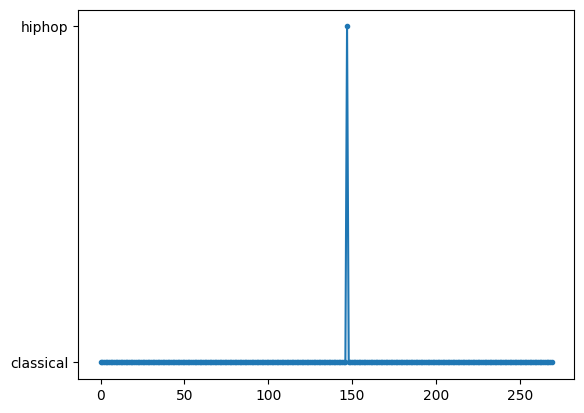

In [ ]:
youtube_dataloader = get_youtube_dataloader("https://www.youtube.com/watch?v=9E6b3swbnWg", labels_str_to_int["classical"])
results = test_convolutional_neural_network(youtube_dataloader, loss_function, cnn_model)
print(f"Chopin - Nocturne: accuracy = {results[2]}")
plt.plot(inference(youtube_dataloader, cnn_model), linestyle=None, marker='o', markersize=3)

From the confusion matrix, we can see that
+ $268 / 270 \approx 99.3\%$ of samples were classified as <code>'classical'</code> (accuracy)
+ $1 / 270 \approx 0.3\%$ of samples was classified as <code>'hiphop'</code>
+ $1 / 270 \approx 0.3\%$ of samples were classified as <code>'rock_metal_hardrock'</code>

### Test 2: Madonna - Hung Up (pop)

There is no pop class in our dataset, so we classify this song as hiphop, which is the closest genre.

Test Error:
Avg loss               : 2.516693
f1 macro averaged score: 0.063969
Accuracy               : 14.7%
Confusion matrix       :
tensor([[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [ 32,  35,  49, 218],
        [  0,   0,   0,   0]], device='cuda:0')
Madonna - Hung Up: accuracy = 14.67065868263473


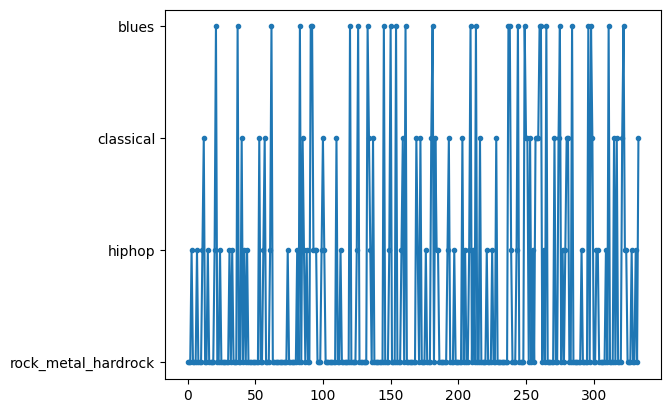

In [ ]:
youtube_dataloader = get_youtube_dataloader("https://www.youtube.com/watch?v=EDwb9jOVRtU", labels_str_to_int["hiphop"])
results = test_convolutional_neural_network(youtube_dataloader, loss_function, cnn_model)
print(f"Madonna - Hung Up: accuracy = {results[2]}")
plt.plot(inference(youtube_dataloader, cnn_model), linestyle=None, marker='o', markersize=3)

From the confusion matrix, we can see that
+ $218 / 334 \approx 65.2\%$ of samples were classified as <code>'rock_metal_hardrock'</code>
+ $49 / 334 \approx 14.6\%$ of samples were classified as <code>'hiphop'</code> (accuracy)
+ $35 / 334 \approx 10\%$ of samples were classified as <code>'blues'</code>
+ $32 / 334 \approx 9.5\%$ of samples were classified as <code>'classical'</code>

### Test 3: Placebo - Every You Every Me (rock)

Test Error:
Avg loss               : 0.337196
f1 macro averaged score: 0.235294
Accuracy               : 88.9%
Confusion matrix       :
tensor([[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [ 16,   5,   3, 192]], device='cuda:0')
Placebo - Every You Every Me: accuracy = 88.88888888888889


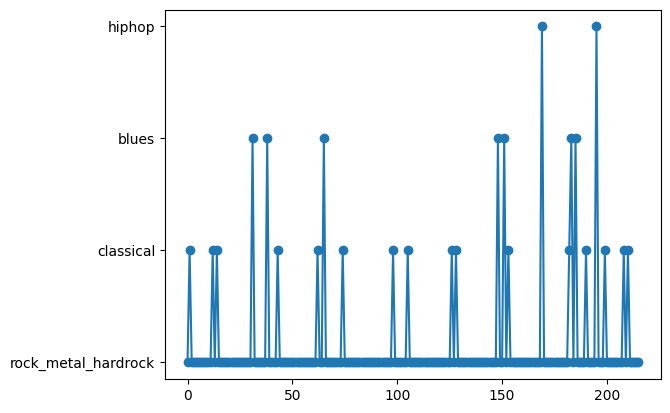

In [ ]:
youtube_dataloader = get_youtube_dataloader("https://www.youtube.com/watch?v=OMaycNcPsHI", labels_str_to_int["rock_metal_hardrock"])
results = test_convolutional_neural_network(youtube_dataloader, loss_function, cnn_model)
print(f"Placebo - Every You Every Me: accuracy = {results[2]}")
plt.plot(inference(youtube_dataloader, cnn_model), marker='o')

From the confusion matrix, we can see that
+ $192 / 216 \approx 88.8\%$ of samples were classified as <code>'rock_metal_hardrock'</code> (accuracy)
+ $16 / 216 \approx 7.4\%$ of samples were classified as <code>'classical'</code>
+ $5 / 216 \approx 2.3\%$ of samples were classified as <code>'blues'</code>
+ $3 / 216 \approx 1.3\%$ of samples were classified as <code>'hiphop'</code>

### Test 4: B.B. King - How Blue Can You Get (blues)

Test Error:
Avg loss               : 1.594254
f1 macro averaged score: 0.140230
Accuracy               : 39.0%
Confusion matrix       :
tensor([[  0,   0,   0,   0],
        [ 34, 122,  52, 105],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]], device='cuda:0')
B.B. King - How Blue Can You Get: accuracy = 38.977635782747605


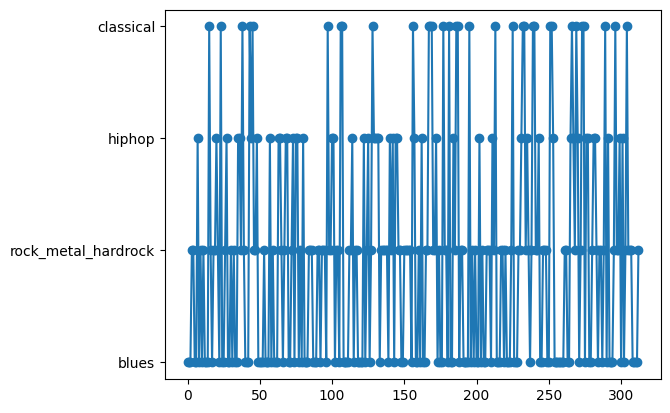

In [ ]:
youtube_dataloader = get_youtube_dataloader("https://www.youtube.com/watch?v=l45f28PzfCI", labels_str_to_int["blues"])
results = test_convolutional_neural_network(youtube_dataloader, loss_function, cnn_model)
print(f"B.B. King - How Blue Can You Get: accuracy = {results[2]}")
plt.plot(inference(youtube_dataloader, cnn_model), marker='o')

From the confusion matrix, we can see that
+ $122 / 313 \approx 39\%$ of samples were classified as <code>'blues'</code> (accuracy)
+ $105 / 313 \approx 33.5\%$ of samples were classified as <code>'rock_metal_hardrock'</code>
+ $52 / 313 \approx 16.6\%$ of samples were classified as <code>'hiphop'</code>
+ $34 / 313 \approx 10.8\%$ of samples were classified as <code>'classical'</code>

### Conclusion

Our model classified $3$ out of $4$ songs successfully, which means that the model has $75\%$ accuracy, which is close to the $79\%$ that was achieved during training-validation.

# Reference

[1] SaturnCloud, *TensorFlow Neural Network Faster on CPU Than GPU Exploring the Reasons*, June 2023, https://saturncloud.io/blog/tensorflow-neural-network-faster-on-cpu-than-gpu-exploring-the-reasons/

[2] DeepAI, *Max Pooling Definition*, https://deepai.org/machine-learning-glossary-and-terms/max-pooling

[3] DeepAI, *Padding Definition*, https://deepai.org/machine-learning-glossary-and-terms/padding

[4] S. L. Smith, P.-J. Kindermans, C. Ying, Q. V. Le, *Don't Decay the Learning Rate, Increase the Batch Size*, 2017, https://arxiv.org/abs/1711.00489